#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/fmg.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5864,1/08/2022,18.230000,18.430000,17.840000,18.209999,18.209999,9219358.0,1.35,2.5,125.0
5865,2/08/2022,17.900000,17.980000,17.469999,17.900000,17.900000,9001051.0,1.35,2.5,125.0
5866,3/08/2022,17.590000,18.080000,17.549999,18.020000,18.020000,5781276.0,1.85,2.5,125.0
5867,4/08/2022,17.980000,18.000000,17.660000,17.660000,17.660000,5632216.0,1.85,2.5,125.0
5868,5/08/2022,17.709999,17.959999,17.660000,17.799999,17.799999,1167998.0,1.85,2.5,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.fmg.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.fmg.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.fmg.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.fmg.delete_one(
    {'Date': last_date}
)


DELETE: 29/08/2022 18.889999389648438


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.fmg.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 19.8700008392334
Previous last date in MongoDb: 26-08-2022. Today's date: 30-08-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'fmg.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-26,20.049999,19.26,19.260000,19.870001,7995973,19.870001
2022-08-29,19.850000,18.76,19.690001,18.889999,10124069,18.889999
2022-08-30,19.360001,18.82,19.000000,18.950001,9286576,18.950001


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,19.850000,18.76,19.690001,18.889999,10124069,18.889999
2022-08-30,19.360001,18.82,19.000000,18.950001,9286576,18.950001


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,19.850000,18.76,19.690001,18.889999,10124069,18.889999,1.85,2.5,125
1,30/08/2022,19.360001,18.82,19.000000,18.950001,9286576,18.950001,1.85,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/08/2022',
  'High': 19.850000381469727,
  'Low': 18.760000228881836,
  'Open': 19.690000534057617,
  'Close': 18.889999389648438,
  'Volume': 10124069,
  'Adj Close': 18.889999389648438,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '30/08/2022',
  'High': 19.360000610351562,
  'Low': 18.81999969482422,
  'Open': 19.0,
  'Close': 18.950000762939453,
  'Volume': 9286576,
  'Adj Close': 18.950000762939453,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [10]:
#INSERT NEW DATA INTO MONGODB
db.fmg.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.fmg.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62ff425e85c180724d411620') '17/08/2022' 19.440000534057617
  19.530000686645508 19.100000381469727 19.229999542236328
  19.229999542236328 5434384.0 1.85 2.5 125.0]
 [ObjectId('62ff425e85c180724d411621') '18/08/2022' 18.940000534057617
  19.1200008392334 18.719999313354492 19.079999923706055
  19.079999923706055 7296867.0 1.85 2.5 125.0]
 [ObjectId('63035ad7b08181375e340493') '19/08/2022' 19.260000228881836
  19.34000015258789 19.149999618530273 19.15999984741211
  19.15999984741211 5912827.0 1.85 2.5 125.0]
 [ObjectId('6304a821e1fa27861e5c6ce9') '22/08/2022' 18.950000762939453
  19.290000915527344 18.700000762939453 19.100000381469727
  19.100000381469727 5592694.0 1.85 2.5 125.0]
 [ObjectId('63072a7d330ff3b4c3fdb34b') '23/08/2022' 19.049999237060547
  19.290000915527344 18.959999084472656 19.040000915527344
  19.040000915527344 4524694.0 1.85 2.5 125.0]
 [ObjectId('63072a7d330ff3b4c3fdb34c') '24/08/2022' 19.309999465942383
  19.600000381469727 19.020000457763672 19.120000

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

30/08/2022 18.950000762939453


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.fmg.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5876, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4701, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.0002211 , 0.0002211 , 0.0002211 , 0.00025844, 0.00025844,
       0.00029575, 0.00033309, 0.00033309, 0.00025844, 0.0002211 ,
       0.0002211 , 0.0002211 , 0.0002211 , 0.00025844, 0.00016512,
       0.00029575, 0.00029575, 0.0002211 , 0.0002211 , 0.00023977,
       0.00023977, 0.00023977, 0.00025844, 0.00020246, 0.00031442,
       0.00033309, 0.00033309, 0.00033309, 0.0003704 , 0.00038907,
       0.00038907, 0.00038907, 0.00038907, 0.00038907, 0.00035176,
       0.00029575, 0.00029575, 0.00035176, 0.0003704 , 0.0005197 ,
       0.0005197 , 0.00044505, 0.00044505, 0.00044505, 0.00048239,
       0.0005197 , 0.00050106, 0.00044505, 0.00044505, 0.00044505,
       0.00044505, 0.00044505, 0.00040774, 0.00040774, 0.0003704 ,
       0.0003704 , 0.00033309, 0.0003704 , 0.0003704 , 0.00033309])]
[0.0003330924982161735]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4641, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4641, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4641/4641 [==============================] - 1389s 294ms/step - loss: 1.9401e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.6861572010341823

C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/4148107487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


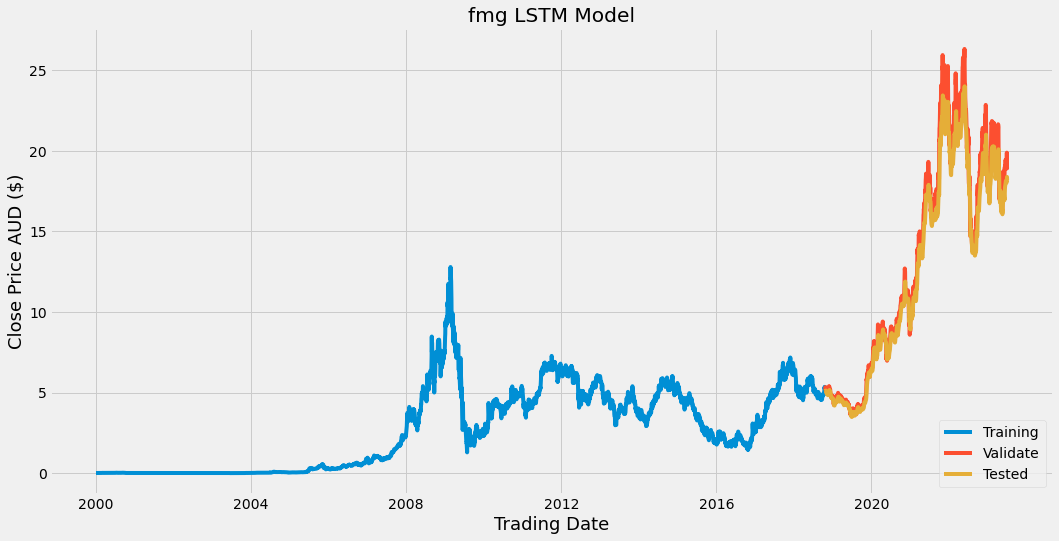

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('fmg LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/fmg_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
4701   5.270000     5.075024    0.194976
4702   5.250000     5.083144    0.166856
4703   5.330000     5.077080    0.252920
4704   5.310000     5.098962    0.211038
4705   5.310000     5.112950    0.197050
...         ...          ...         ...
5871  19.120001    18.010849    1.109152
5872  19.139999    18.031254    1.108746
5873  19.870001    18.060223    1.809778
5874  18.889999    18.365692    0.524307
5875  18.950001    18.180309    0.769691

[1175 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.fmg.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $18.950000762939453 Predicted next day share price $17.86


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/fmg_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list fmg_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/fmg_model.sav')

In [32]:
# query the fmg collection and load into dataframe

df_mongo = pd.DataFrame(list(db.fmg.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[21.1       ],
       [21.34      ],
       [21.43      ],
       [20.450001  ],
       [19.299999  ],
       [19.52      ],
       [19.559999  ],
       [18.6       ],
       [16.93      ],
       [17.15      ],
       [17.370001  ],
       [16.73      ],
       [16.870001  ],
       [17.6       ],
       [18.110001  ],
       [18.309999  ],
       [17.530001  ],
       [17.        ],
       [16.870001  ],
       [17.07      ],
       [16.389999  ],
       [16.709999  ],
       [17.219999  ],
       [16.85      ],
       [16.559999  ],
       [16.530001  ],
       [17.1       ],
       [16.24      ],
       [16.35      ],
       [16.98      ],
       [17.280001  ],
       [17.32      ],
       [17.51      ],
       [18.01      ],
       [18.299999  ],
       [18.049999  ],
       [18.219999  ],
       [18.120001  ],
       [17.84      ],
       [17.469999  ],
       [17.549999  ],
       [17.66      ],
       [17.65999985],
       [18.34000015],
       [18.79999924],
       [18

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/fmg_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_fmg(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_fmg(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[18.78,
 18.72,
 18.68,
 18.62,
 18.55,
 18.5,
 18.46,
 18.4,
 18.36,
 18.32,
 18.28,
 18.25,
 18.21,
 18.18,
 18.15,
 18.12,
 18.09,
 18.06,
 18.04,
 18.01,
 17.98,
 17.96,
 17.93,
 17.91,
 17.88,
 17.86,
 17.84,
 17.82,
 17.8,
 17.82,
 17.82,
 17.82,
 17.83,
 17.83,
 17.83,
 17.82,
 17.82,
 17.82,
 17.82,
 17.81,
 17.81,
 17.81,
 17.81,
 17.81,
 17.81,
 17.8,
 17.8,
 17.8,
 17.8,
 17.8,
 17.8,
 17.8,
 17.79,
 17.79,
 17.79,
 17.79,
 17.79,
 17.79,
 17.79,
 17.79,
 17.79,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 17.78,
 1

In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [35]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')

#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')
today_str=today1.strftime('%d-%m-%Y')
print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')
    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)
    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[10:].values
    print(dates_val)

2022-08-31 00:00:00 2022-08-30 00:00:00
5:21:57.269976
[[ObjectId('630dc684ae0967d012939261') 11 '14-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939262') 12 '15-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939263') 13 '16-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939264') 14 '19-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d012939265') 15 '20-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d012939266') 16 '21-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939267') 17 '22-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939268') 18 '23-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939269') 19 '26-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d01293926a') 20 '27-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d01293926b') 21 '28-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d01293926c') 22 '29-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d01293926d') 23 '30-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d01293926e') 24 '03-10-2022' 'Monday']
 [ObjectId('630dc6

In [36]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,31-08-2022,Wednesday
1,2,01-09-2022,Thursday
2,3,02-09-2022,Friday
3,4,05-09-2022,Monday
4,5,06-09-2022,Tuesday
...,...,...,...
203,204,12-06-2023,Monday
204,205,13-06-2023,Tuesday
205,206,14-06-2023,Wednesday
206,207,15-06-2023,Thursday


In [37]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
d=dates_df.iloc[0,2]+"  "+dates_df.iloc[0,3]
print(d)

31-08-2022  Wednesday


C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/3597525660.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


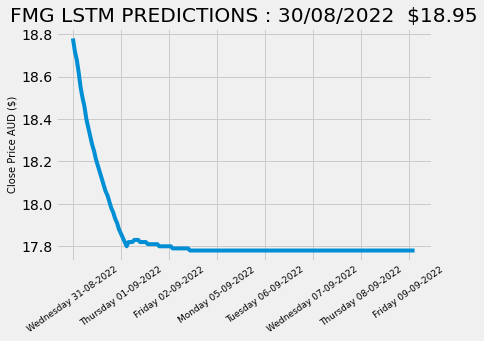

In [38]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('FMG LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
# plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/fmg_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('630dc684ae0967d012939257'), 'Count': 1, 'Date': '31-08-2022', 'DOW': 'Wednesday', 'Price': 18.78}


In [40]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


4701 5876 6039


C:\Users\antoi\AppData\Local\Temp/ipykernel_24856/2118392301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


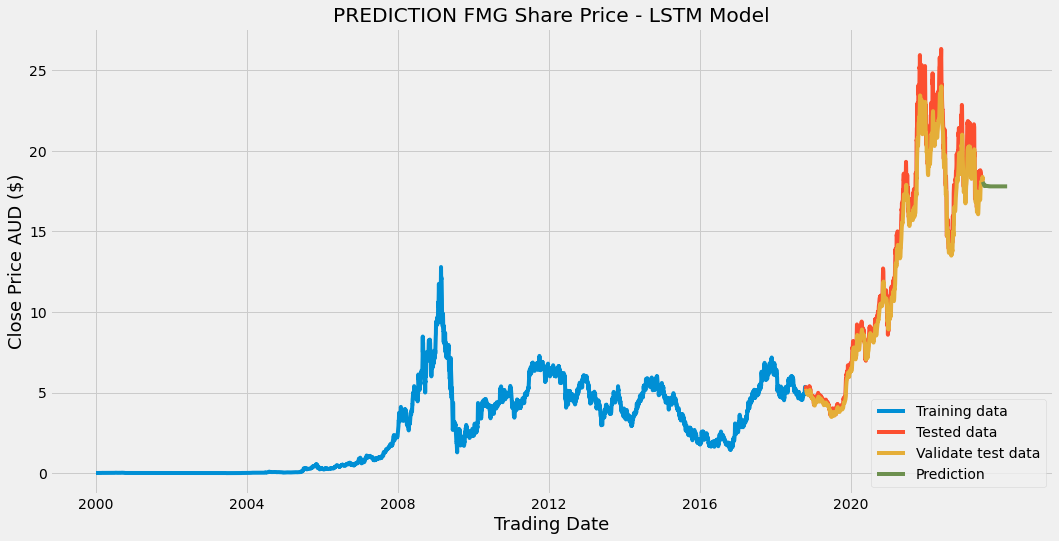

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION FMG Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/fmg_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Query all
name = 'FMG'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77e2f2a827b19bf6473c2'), 'model': 'RFR', 'name': 'FMG', 'date': '12/08/2022', 'predicted': 12, 'actual': 18, 'difference': -5.0768, 'accuracy': 91.24}
{'_id': ObjectId('630c8ec18b7907a16afd954e'), 'model': 'LSTM', 'name': 'FMG', 'date': '29/08/2022', 'predicted': 18.36, 'actual': 18.89, 'difference': -0.53, 'rmse': 0.47329}


In [43]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77e2f2a827b19bf6473c2'), 'model': 'RFR', 'name': 'FMG', 'date': '12/08/2022', 'predicted': 12, 'actual': 18, 'difference': -5.0768, 'accuracy': 91.24}


In [44]:
# Set keys and values of company
name = 'FMG'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022,predicted $17.86, actual $18.95, difference -1.0899999999999999, rmse 0.68616


In [45]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77e2f2a827b19bf6473c2'), 'model': 'RFR', 'name': 'FMG', 'date': '12/08/2022', 'predicted': 12, 'actual': 18, 'difference': -5.0768, 'accuracy': 91.24}
{'_id': ObjectId('630dcc6bf52ded7e84807581'), 'model': 'LSTM', 'name': 'FMG', 'date': '30/08/2022', 'predicted': 17.86, 'actual': 18.95, 'difference': -1.09, 'rmse': 0.68616}


In [46]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'

In [47]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'